In [1]:
%cd ~/dissertation_code 
import sys
sys.path.append("RQ 3/")
import DecisionTreeSubgroupDiscovery as dtsd

from collections import Counter
import numpy as np
import pandas as pd
import itertools

import tensorflow
tensorflow.random.set_seed(2) # tensorflow seed fixing

/home/tntech.edu/kebrown46/dissertation_code


In [2]:
def run_experiment(res_key, include_probability = False, selection_criteria="amia"):
    %mkdir RQ\ 3/results/{res_key}
    %mkdir RQ\ 3/input/{res_key}
    datasets = ["trauma_uk", "diabetes", "ED_3day_readmit", "hospitalization_prediction", "critical_outcome"]
    # datasets = ["trauma_uk"]
    models = ["NN-dropout", "catboost-ve"]
    n_bins_list = [2,3]
    combos = list(itertools.product(datasets, models))
    n_trials = len(combos) * 10
    i = 0
    for dataset, model in combos:
        res_results = []
        for n_bins in n_bins_list:

            # for iteration in range(10):
            for iteration in range(1):
                i += 1
                print(f"TRIAL {i}/{n_trials}")
                res = {
                    "model": model,
                    "dataset": dataset,
                    "iteration": iteration,
                    "no_bins": n_bins
                }
                print(f"====={model} {dataset} {iteration} {n_bins}=====")
                train_df, test_df, train_ycls, test_ycls = dtsd.read_data(iteration, 
                                                                          model, 
                                                                          dataset, 
                                                                          n_bins, 
                                                                          bin_split="qcut", 
                                                                          include_probability=include_probability,
                                                                          res_key = res_key)
                features = list(train_df)
                while "uncertainty group" in features: features.remove("uncertainty group")
                print(features)
                train_X_unc = train_df[features]
                test_X_unc = test_df[features]
                train_y_unc = train_df["uncertainty group"]
                test_y_unc = test_df["uncertainty group"]
                dtc = dtsd.decision_tree_sgd(dataset, model, iteration, train_X_unc, train_y_unc, n_bins = n_bins, res_key=res_key, selection_criteria = selection_criteria)
                rules = dtsd.get_rules(dtc, list(train_X_unc), [f"uncertainty level {i}" for i in range(n_bins)])
                variables = dtsd.get_variables(dtc, list(train_X_unc), [f"uncertainty level {i}" for i in range(n_bins)])
                print(variables)
                dtsd.write_rules_to_file(rules, iteration, model, dataset, n_bins, res_key=res_key)
                test_score = dtc.score(test_X_unc, test_y_unc)
                num_subgroups = dtc.get_n_leaves()
                res["test bin assignment accuracy"] = test_score
                res["no_rules"] = num_subgroups
                res["max_depth"] = dtc.get_depth()
                res["max_features"] = dtc.max_features_
                print(f"test accuracy = {test_score} | num. rules = {num_subgroups}")
                train_adf = dtsd.produce_assignment_file(dtc, 
                                                         train_X_unc, 
                                                         train_y_unc, 
                                                         iteration, 
                                                         n_bins, 
                                                         model, 
                                                         dataset, 
                                                         is_train=True,
                                                         res_key = res_key)
                test_adf = dtsd.produce_assignment_file(dtc, 
                                                        test_X_unc, 
                                                        test_y_unc, 
                                                        iteration, 
                                                        n_bins, 
                                                        model, 
                                                        dataset, 
                                                        is_train=False,
                                                        res_key = res_key)

                res.update(dtsd.produce_statistics_file(train_adf, "train", dtc.get_n_leaves(), model, dataset, variables))
                res.update(dtsd.produce_statistics_file(test_adf, "test", dtc.get_n_leaves(), model, dataset, variables))
                res_results.append(res)
        res_df = pd.DataFrame(res_results)
        columns_not_to_sort = ["model", "dataset", "iteration", "test bin assignment accuracy", "no_rules", "max_depth", "max_features"]
        columns_to_sort = list(res_df)
        for c in columns_not_to_sort:
            while c in columns_to_sort: columns_to_sort.remove(c)
        columns_to_sort.sort()
        columns = columns_not_to_sort + columns_to_sort
        res_df = res_df[columns]
        res_df.to_csv(f"RQ 3/results/{res_key}/subgroup_statistics_{model}_DT_{dataset}.csv")
    


mkdir: cannot create directory ‘RQ 3/results/dissertation_DT_noProb_alpha_newtest’: File exists
mkdir: cannot create directory ‘RQ 3/input/dissertation_DT_noProb_alpha_newtest’: File exists
TRIAL 1/100
=====NN-dropout trauma_uk 0 2=====
['TRAUMATYPE', 'SYSBP', 'RR', 'GCS', 'EDMOTOR', 'SI', 'SIRANK', 'AGE', 'SEX', 'RTS', 'FlailAMPT', 'SCIAMPT', 'RRAMPT', 'GCSAMPT', 'ABDAMPT', 'ARMAMPT', 'CHESTAMPT', 'FACEAMPT', 'HEADAMPT', 'LEGAMPT', 'NECKAMPT', 'MultisystemAMPT', 'AnatomicalAMPT', 'PhysiologicalAMPT', 'LungAMPT', 'AMPT', 'Mechanism', 'RTSCode', 'AgeGroups', 'SBPCode', 'MotorCode', 'AMPT2']
TRAIN SHAPE:  (43519, 32)
min_samples_leaf = 0.01 | ccp_alpha = 0.0 | val_score = 0.8634114583333333 | no. subgroups = 62 | max rule len = 12
min_samples_leaf = 0.01 | ccp_alpha = 5.969774669395888e-05 | val_score = 0.8634114583333333 | no. subgroups = 40 | max rule len = 9
min_samples_leaf = 0.01 | ccp_alpha = 8.127293519086254e-05 | val_score = 0.8634114583333333 | no. subgroups = 39 | max rule len

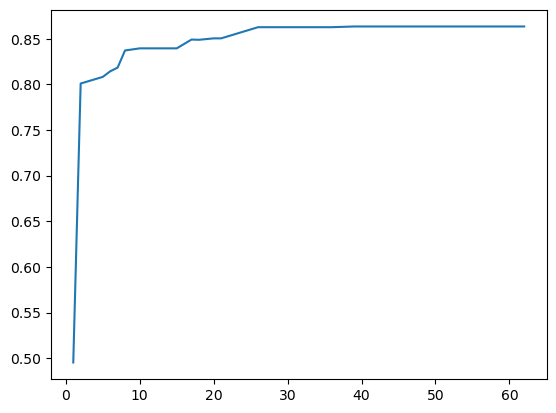

min_samples_leaf     0.010000
ccp_alpha            0.000081
score                0.863411
num_subgroups       39.000000
max rule len         9.000000
Name: 2, dtype: float64
Leaf Order:  [6, 7, 8, 12, 13, 14, 15, 21, 22, 23, 26, 27, 28, 29, 31, 32, 38, 39, 40, 41, 42, 43, 49, 52, 53, 56, 57, 58, 60, 62, 64, 65, 67, 68, 71, 72, 73, 75, 76]
Leaf Order:  [6, 7, 8, 12, 13, 14, 15, 21, 22, 23, 26, 27, 28, 29, 31, 32, 38, 39, 40, 41, 42, 43, 49, 52, 53, 56, 57, 58, 60, 62, 64, 65, 67, 68, 71, 72, 73, 75, 76]
[['AMPT', 'CHESTAMPT', 'HEADAMPT', 'ABDAMPT', 'NECKAMPT', 'SYSBP'], ['AMPT', 'CHESTAMPT', 'HEADAMPT', 'ABDAMPT', 'NECKAMPT', 'SYSBP'], ['AMPT', 'CHESTAMPT', 'HEADAMPT', 'ABDAMPT', 'NECKAMPT'], ['AMPT', 'CHESTAMPT', 'HEADAMPT', 'ABDAMPT', 'TRAUMATYPE', 'LEGAMPT', 'AGE'], ['AMPT', 'CHESTAMPT', 'HEADAMPT', 'ABDAMPT', 'TRAUMATYPE', 'LEGAMPT', 'AGE'], ['AMPT', 'CHESTAMPT', 'HEADAMPT', 'ABDAMPT', 'TRAUMATYPE', 'LEGAMPT'], ['AMPT', 'CHESTAMPT', 'HEADAMPT', 'ABDAMPT', 'TRAUMATYPE'], ['AMPT', 'CH

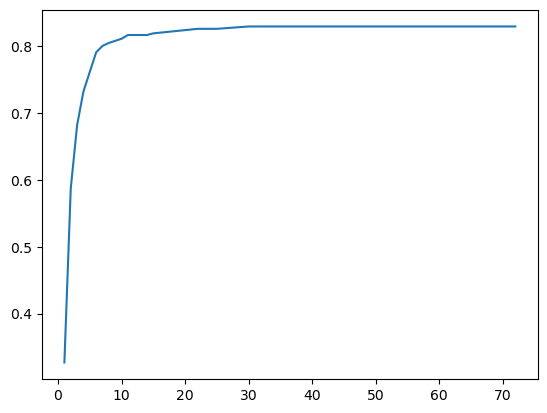

min_samples_leaf     0.010000
ccp_alpha            0.000434
score                0.829297
num_subgroups       30.000000
max rule len         9.000000
Name: 10, dtype: float64
Leaf Order:  [5, 6, 7, 10, 11, 12, 15, 17, 18, 20, 21, 30, 31, 33, 34, 37, 38, 39, 42, 43, 44, 46, 48, 49, 51, 52, 54, 55, 57, 58]
Leaf Order:  [5, 6, 7, 10, 11, 12, 15, 17, 18, 20, 21, 30, 31, 33, 34, 37, 38, 39, 42, 43, 44, 46, 48, 49, 51, 52, 54, 55, 57, 58]
[['AMPT', 'HEADAMPT', 'ABDAMPT', 'CHESTAMPT', 'NECKAMPT'], ['AMPT', 'HEADAMPT', 'ABDAMPT', 'CHESTAMPT', 'NECKAMPT'], ['AMPT', 'HEADAMPT', 'ABDAMPT', 'CHESTAMPT'], ['AMPT', 'HEADAMPT', 'ABDAMPT', 'TRAUMATYPE', 'SI'], ['AMPT', 'HEADAMPT', 'ABDAMPT', 'TRAUMATYPE', 'SI'], ['AMPT', 'HEADAMPT', 'ABDAMPT', 'TRAUMATYPE'], ['AMPT', 'HEADAMPT', 'AGE', 'Mechanism'], ['AMPT', 'HEADAMPT', 'AGE', 'Mechanism', 'AGE'], ['AMPT', 'HEADAMPT', 'AGE', 'Mechanism', 'AGE'], ['AMPT', 'HEADAMPT', 'AGE', 'Mechanism'], ['AMPT', 'HEADAMPT', 'AGE', 'Mechanism'], ['AMPT', 'AMPT', 'RR', 

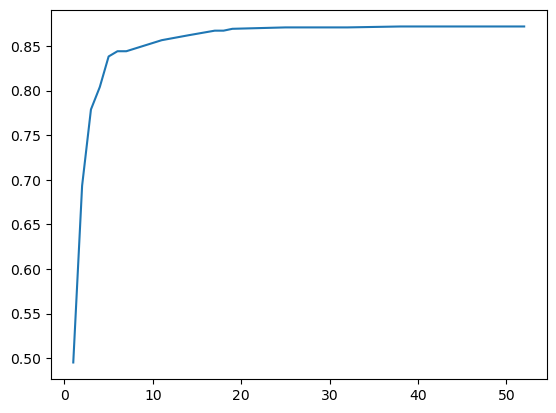

min_samples_leaf     0.010000
ccp_alpha            0.000191
score                0.871745
num_subgroups       38.000000
max rule len        11.000000
Name: 4, dtype: float64
Leaf Order:  [5, 7, 8, 10, 11, 15, 16, 18, 19, 20, 25, 26, 27, 28, 31, 32, 34, 35, 40, 45, 47, 49, 50, 51, 53, 55, 56, 58, 60, 61, 64, 65, 68, 69, 71, 72, 73, 76, 77, 78]
Leaf Order:  [5, 7, 8, 10, 11, 15, 16, 18, 19, 20, 25, 26, 27, 28, 31, 32, 34, 35, 40, 45, 47, 49, 50, 51, 53, 55, 56, 58, 60, 61, 64, 65, 68, 69, 71, 72, 73, 76, 77, 78]
[['HEADAMPT', 'AMPT', 'ABDAMPT', 'NECKAMPT', 'CHESTAMPT'], ['HEADAMPT', 'AMPT', 'ABDAMPT', 'NECKAMPT', 'CHESTAMPT', 'RR'], ['HEADAMPT', 'AMPT', 'ABDAMPT', 'NECKAMPT', 'CHESTAMPT', 'RR'], ['HEADAMPT', 'AMPT', 'ABDAMPT', 'NECKAMPT', 'AGE'], ['HEADAMPT', 'AMPT', 'ABDAMPT', 'NECKAMPT', 'AGE'], ['HEADAMPT', 'AMPT', 'ABDAMPT', 'CHESTAMPT', 'SI', 'RR'], ['HEADAMPT', 'AMPT', 'ABDAMPT', 'CHESTAMPT', 'SI', 'RR'], ['HEADAMPT', 'AMPT', 'ABDAMPT', 'CHESTAMPT', 'SI', 'SI'], ['HEADAMPT', 'AMPT'

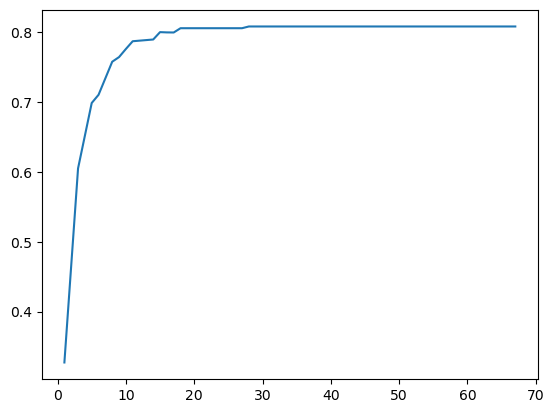

min_samples_leaf     0.010000
ccp_alpha            0.000705
score                0.807682
num_subgroups       28.000000
max rule len         9.000000
Name: 12, dtype: float64
Leaf Order:  [6, 7, 8, 9, 13, 14, 15, 16, 20, 21, 23, 24, 25, 34, 35, 37, 38, 39, 40, 41, 43, 44, 47, 48, 50, 52, 53, 55, 57, 58]
Leaf Order:  [6, 7, 8, 9, 13, 14, 15, 16, 20, 21, 23, 24, 25, 34, 35, 37, 38, 39, 40, 41, 43, 44, 47, 48, 50, 52, 53, 55, 57, 58]
[['AMPT', 'HEADAMPT', 'ABDAMPT', 'CHESTAMPT', 'NECKAMPT', 'SYSBP'], ['AMPT', 'HEADAMPT', 'ABDAMPT', 'CHESTAMPT', 'NECKAMPT', 'SYSBP'], ['AMPT', 'HEADAMPT', 'ABDAMPT', 'CHESTAMPT', 'NECKAMPT'], ['AMPT', 'HEADAMPT', 'ABDAMPT', 'CHESTAMPT'], ['AMPT', 'HEADAMPT', 'ABDAMPT', 'CHESTAMPT', 'SI', 'RR'], ['AMPT', 'HEADAMPT', 'ABDAMPT', 'CHESTAMPT', 'SI', 'RR'], ['AMPT', 'HEADAMPT', 'ABDAMPT', 'CHESTAMPT', 'SI'], ['AMPT', 'HEADAMPT', 'ABDAMPT', 'CHESTAMPT'], ['AMPT', 'HEADAMPT', 'AGE', 'Mechanism', 'GCS'], ['AMPT', 'HEADAMPT', 'AGE', 'Mechanism', 'GCS'], ['AMPT', 'HEAD

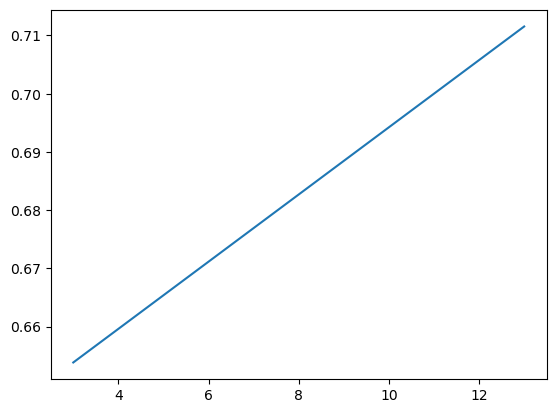

min_samples_leaf     0.010000
ccp_alpha            0.000000
score                0.711538
num_subgroups       13.000000
max rule len         4.000000
Name: 0, dtype: float64
Leaf Order:  [4, 5, 7, 8, 10, 11, 15, 16, 18, 19, 22, 23, 24]
Leaf Order:  [4, 5, 7, 8, 10, 11, 15, 16, 18, 19, 22, 23, 24]
[['Glucose', 'BMI', 'Pregnancies', 'BloodPressure'], ['Glucose', 'BMI', 'Pregnancies', 'BloodPressure'], ['Glucose', 'BMI', 'Pregnancies', 'SkinThickness'], ['Glucose', 'BMI', 'Pregnancies', 'SkinThickness'], ['Glucose', 'BMI', 'BloodPressure'], ['Glucose', 'BMI', 'BloodPressure'], ['Glucose', 'Glucose', 'SkinThickness', 'Pregnancies'], ['Glucose', 'Glucose', 'SkinThickness', 'Pregnancies'], ['Glucose', 'Glucose', 'SkinThickness', 'SkinThickness'], ['Glucose', 'Glucose', 'SkinThickness', 'SkinThickness'], ['Glucose', 'Glucose', 'Insulin', 'BloodPressure'], ['Glucose', 'Glucose', 'Insulin', 'BloodPressure'], ['Glucose', 'Glucose', 'Insulin']]
test accuracy = 0.7662337662337663 | num. rules = 13

/home/tntech.edu/kebrown46/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/tntech.edu/kebrown46/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tntech.edu/kebrown46/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/tntech.edu/kebrown46/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tntech.edu/kebrown46/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/tntech.edu/kebrown46/miniconda3/envs/py38/lib/pyt

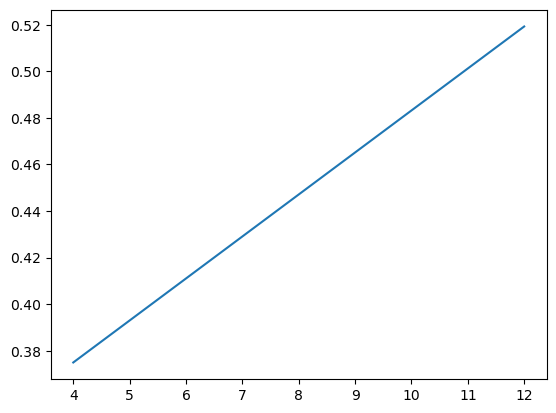

min_samples_leaf     0.010000
ccp_alpha            0.000000
score                0.519231
num_subgroups       12.000000
max rule len         4.000000
Name: 0, dtype: float64
Leaf Order:  [4, 5, 7, 8, 11, 12, 14, 15, 17, 20, 21, 22]
Leaf Order:  [4, 5, 7, 8, 11, 12, 14, 15, 17, 20, 21, 22]
[['Glucose', 'Glucose', 'BMI', 'Pregnancies'], ['Glucose', 'Glucose', 'BMI', 'Pregnancies'], ['Glucose', 'Glucose', 'BMI', 'Age'], ['Glucose', 'Glucose', 'BMI', 'Age'], ['Glucose', 'Glucose', 'Glucose', 'Pregnancies'], ['Glucose', 'Glucose', 'Glucose', 'Pregnancies'], ['Glucose', 'Glucose', 'Glucose', 'Age'], ['Glucose', 'Glucose', 'Glucose', 'Age'], ['Glucose', 'BMI'], ['Glucose', 'BMI', 'Insulin', 'Glucose'], ['Glucose', 'BMI', 'Insulin', 'Glucose'], ['Glucose', 'BMI', 'Insulin']]
test accuracy = 0.6363636363636364 | num. rules = 12
TRIAL 7/100
=====catboost-ve diabetes 0 2=====
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
TRAIN SH

/home/tntech.edu/kebrown46/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/tntech.edu/kebrown46/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tntech.edu/kebrown46/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/tntech.edu/kebrown46/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tntech.edu/kebrown46/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/tntech.edu/kebrown46/miniconda3/envs/py38/lib/pyt

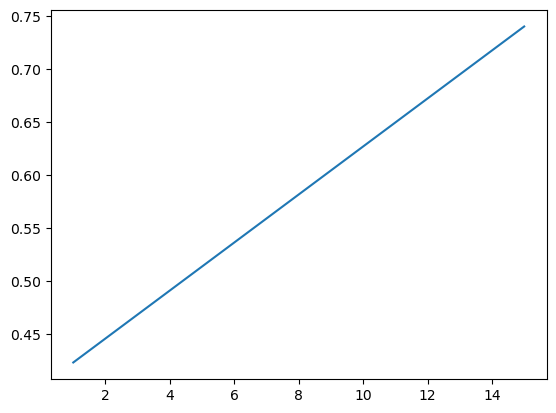

min_samples_leaf     0.010000
ccp_alpha            0.000000
score                0.740385
num_subgroups       15.000000
max rule len         4.000000
Name: 0, dtype: float64
Leaf Order:  [4, 5, 6, 8, 10, 11, 15, 16, 18, 19, 22, 23, 25, 26]
Leaf Order:  [4, 5, 6, 8, 10, 11, 15, 16, 18, 19, 22, 23, 25, 26]
[['BMI', 'Pregnancies', 'Glucose', 'Age'], ['BMI', 'Pregnancies', 'Glucose', 'Age'], ['BMI', 'Pregnancies', 'Glucose'], ['BMI', 'Pregnancies', 'Glucose'], ['BMI', 'Pregnancies', 'Glucose', 'Glucose'], ['BMI', 'Pregnancies', 'Glucose', 'Glucose'], ['BMI', 'Age', 'Glucose', 'Glucose'], ['BMI', 'Age', 'Glucose', 'Glucose'], ['BMI', 'Age', 'Glucose', 'DiabetesPedigreeFunction'], ['BMI', 'Age', 'Glucose', 'DiabetesPedigreeFunction'], ['BMI', 'Age', 'Glucose', 'Glucose'], ['BMI', 'Age', 'Glucose', 'Glucose'], ['BMI', 'Age', 'Glucose', 'BMI'], ['BMI', 'Age', 'Glucose', 'BMI']]
test accuracy = 0.8571428571428571 | num. rules = 14
TRIAL 8/100
=====catboost-ve diabetes 0 3=====
['Pregnancies', '

/home/tntech.edu/kebrown46/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/tntech.edu/kebrown46/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tntech.edu/kebrown46/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/tntech.edu/kebrown46/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


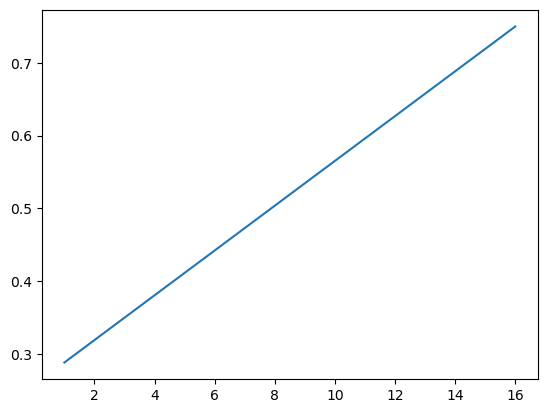

min_samples_leaf     0.01
ccp_alpha            0.00
score                0.75
num_subgroups       16.00
max rule len         4.00
Name: 0, dtype: float64
Leaf Order:  [4, 5, 7, 8, 11, 12, 14, 15, 19, 20, 22, 23, 26, 27, 29, 30]
Leaf Order:  [4, 5, 7, 8, 11, 12, 14, 15, 19, 20, 22, 23, 26, 27, 29, 30]
[['Age', 'BMI', 'Glucose', 'Pregnancies'], ['Age', 'BMI', 'Glucose', 'Pregnancies'], ['Age', 'BMI', 'Glucose', 'Age'], ['Age', 'BMI', 'Glucose', 'Age'], ['Age', 'BMI', 'Glucose', 'SkinThickness'], ['Age', 'BMI', 'Glucose', 'SkinThickness'], ['Age', 'BMI', 'Glucose', 'Glucose'], ['Age', 'BMI', 'Glucose', 'Glucose'], ['Age', 'Glucose', 'BMI', 'Glucose'], ['Age', 'Glucose', 'BMI', 'Glucose'], ['Age', 'Glucose', 'BMI', 'Glucose'], ['Age', 'Glucose', 'BMI', 'Glucose'], ['Age', 'Glucose', 'BMI', 'Insulin'], ['Age', 'Glucose', 'BMI', 'Insulin'], ['Age', 'Glucose', 'BMI', 'DiabetesPedigreeFunction'], ['Age', 'Glucose', 'BMI', 'DiabetesPedigreeFunction']]
test accuracy = 0.7922077922077922 | num. r

/home/tntech.edu/kebrown46/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/tntech.edu/kebrown46/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tntech.edu/kebrown46/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/tntech.edu/kebrown46/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tntech.edu/kebrown46/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/tntech.edu/kebrown46/miniconda3/envs/py38/lib/pyt

['age', 'gender', 'n_ed_30d', 'n_ed_90d', 'n_ed_365d', 'n_hosp_30d', 'n_hosp_90d', 'n_hosp_365d', 'n_icu_30d', 'n_icu_90d', 'n_icu_365d', 'triage_pain', 'triage_acuity', 'chiefcom_chest_pain', 'chiefcom_abdominal_pain', 'chiefcom_headache', 'chiefcom_shortness_of_breath', 'chiefcom_back_pain', 'chiefcom_cough', 'chiefcom_nausea_vomiting', 'chiefcom_fever_chills', 'chiefcom_syncope', 'chiefcom_dizziness', 'cci_MI', 'cci_CHF', 'cci_PVD', 'cci_Stroke', 'cci_Dementia', 'cci_Pulmonary', 'cci_Rheumatic', 'cci_PUD', 'cci_Liver1', 'cci_DM1', 'cci_DM2', 'cci_Paralysis', 'cci_Renal', 'cci_Cancer1', 'cci_Liver2', 'cci_Cancer2', 'cci_HIV', 'eci_Arrhythmia', 'eci_Valvular', 'eci_PHTN', 'eci_HTN1', 'eci_HTN2', 'eci_NeuroOther', 'eci_Hypothyroid', 'eci_Lymphoma', 'eci_Coagulopathy', 'eci_Obesity', 'eci_WeightLoss', 'eci_FluidsLytes', 'eci_BloodLoss', 'eci_Anemia', 'eci_Alcohol', 'eci_Drugs', 'eci_Psychoses', 'eci_Depression', 'ed_temperature_last', 'ed_heartrate_last', 'ed_resprate_last', 'ed_o2sat_l

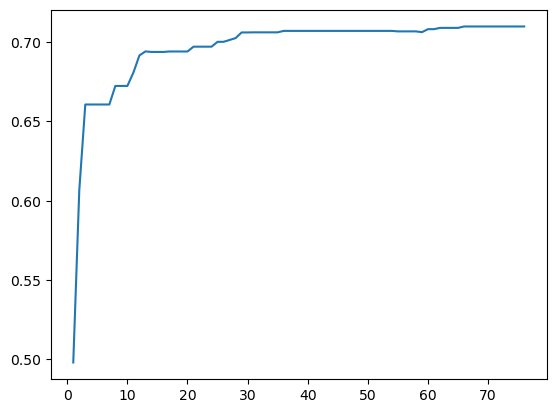

min_samples_leaf     0.010000
ccp_alpha            0.000093
score                0.709753
num_subgroups       66.000000
max rule len        10.000000
Name: 10, dtype: float64
Leaf Order:  [7, 8, 9, 10, 15, 16, 17, 19, 21, 22, 23, 30, 31, 32, 35, 36, 38, 39, 40, 45, 46, 48, 49, 51, 53, 54, 56, 57, 59, 60, 65, 66, 68, 71, 72, 74, 75, 77, 78, 82, 83, 84, 87, 89, 90, 93, 95, 96, 98, 99, 104, 105, 108, 109, 111, 112, 115, 117, 118, 121, 122, 125, 126, 127, 131, 132, 133, 134]
Leaf Order:  [7, 8, 9, 10, 15, 16, 17, 19, 21, 22, 23, 30, 31, 32, 35, 36, 38, 39, 40, 45, 46, 48, 49, 51, 53, 54, 56, 57, 59, 60, 65, 66, 68, 71, 72, 74, 75, 77, 78, 82, 83, 84, 87, 89, 90, 93, 95, 96, 98, 99, 104, 105, 108, 109, 111, 112, 115, 117, 118, 121, 122, 125, 126, 127, 131, 132, 133, 134]
[['n_ed_90d', 'triage_pain', 'triage_acuity', 'age', 'n_med', 'triage_pain', 'gender'], ['n_ed_90d', 'triage_pain', 'triage_acuity', 'age', 'n_med', 'triage_pain', 'gender'], ['n_ed_90d', 'triage_pain', 'triage_acuity', 'ag

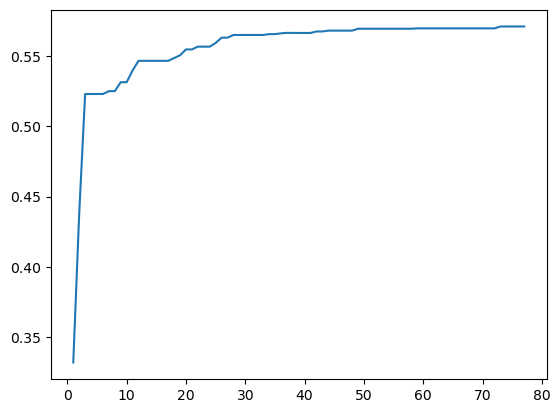

min_samples_leaf     0.010000
ccp_alpha            0.000042
score                0.571047
num_subgroups       73.000000
max rule len        10.000000
Name: 4, dtype: float64
Leaf Order:  [6, 7, 8, 12, 13, 14, 15, 22, 23, 24, 25, 26, 29, 30, 33, 34, 35, 37, 39, 40, 49, 50, 52, 53, 55, 56, 57, 58, 63, 64, 65, 67, 68, 71, 72, 75, 76, 77, 80, 81, 82, 87, 88, 90, 91, 92, 96, 97, 98, 101, 102, 105, 106, 107, 112, 113, 115, 116, 120, 121, 122, 125, 126, 128, 129, 133, 134, 137, 138, 139, 141, 142]
Leaf Order:  [6, 7, 8, 12, 13, 14, 15, 22, 23, 24, 25, 26, 29, 30, 33, 34, 35, 37, 39, 40, 49, 50, 52, 53, 55, 56, 57, 58, 63, 64, 65, 67, 68, 71, 72, 75, 76, 77, 80, 81, 82, 87, 88, 90, 91, 92, 96, 97, 98, 101, 102, 105, 106, 107, 112, 113, 115, 116, 120, 121, 122, 125, 126, 128, 129, 133, 134, 137, 138, 139, 141, 142]
[['n_ed_90d', 'triage_acuity', 'age', 'triage_pain', 'n_med', 'gender'], ['n_ed_90d', 'triage_acuity', 'age', 'triage_pain', 'n_med', 'gender'], ['n_ed_90d', 'triage_acuity', 'age', 

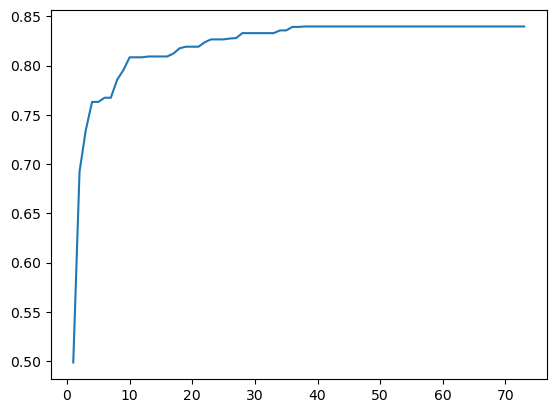

min_samples_leaf     0.010000
ccp_alpha            0.000535
score                0.839648
num_subgroups       38.000000
max rule len         8.000000
Name: 32, dtype: float64
Leaf Order:  [3, 6, 8, 9, 13, 15, 16, 17, 19, 20, 25, 26, 27, 30, 31, 33, 34, 38, 39, 40, 42, 44, 45, 51, 52, 53, 54, 57, 58, 59, 65, 66, 67, 68, 69, 73, 74, 75, 77, 78]
Leaf Order:  [3, 6, 8, 9, 13, 15, 16, 17, 19, 20, 25, 26, 27, 30, 31, 33, 34, 38, 39, 40, 42, 44, 45, 51, 52, 53, 54, 57, 58, 59, 65, 66, 67, 68, 69, 73, 74, 75, 77, 78]
[['triage_pain', 'n_ed_365d', 'triage_acuity'], ['triage_pain', 'n_ed_365d', 'triage_acuity', 'ed_heartrate_last', 'n_med'], ['triage_pain', 'n_ed_365d', 'triage_acuity', 'ed_heartrate_last', 'n_med', 'age'], ['triage_pain', 'n_ed_365d', 'triage_acuity', 'ed_heartrate_last', 'n_med', 'age'], ['triage_pain', 'n_ed_365d', 'triage_acuity', 'ed_heartrate_last', 'n_medrecon', 'ed_los', 'n_medrecon'], ['triage_pain', 'n_ed_365d', 'triage_acuity', 'ed_heartrate_last', 'n_medrecon', 'ed_l

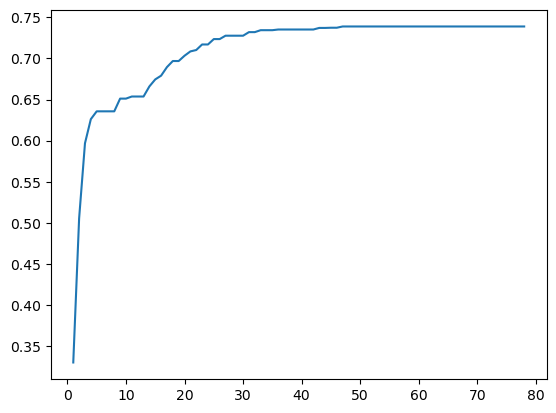

min_samples_leaf     0.010000
ccp_alpha            0.000785
score                0.738883
num_subgroups       47.000000
max rule len         8.000000
Name: 30, dtype: float64
Leaf Order:  [6, 7, 10, 11, 12, 14, 16, 17, 20, 21, 24, 25, 26, 30, 31, 33, 34, 36, 37, 43, 46, 47, 48, 50, 51, 56, 57, 58, 60, 61, 64, 65, 67, 68, 70, 71, 77, 79, 80, 82, 83, 84, 86, 87, 89, 91, 92]
Leaf Order:  [6, 7, 10, 11, 12, 14, 16, 17, 20, 21, 24, 25, 26, 30, 31, 33, 34, 36, 37, 43, 46, 47, 48, 50, 51, 56, 57, 58, 60, 61, 64, 65, 67, 68, 70, 71, 77, 79, 80, 82, 83, 84, 86, 87, 89, 91, 92]
[['triage_acuity', 'triage_pain', 'n_ed_90d', 'age', 'ed_heartrate_last', 'n_med'], ['triage_acuity', 'triage_pain', 'n_ed_90d', 'age', 'ed_heartrate_last', 'n_med'], ['triage_acuity', 'triage_pain', 'n_ed_90d', 'age', 'ed_heartrate_last', 'ed_los', 'n_medrecon'], ['triage_acuity', 'triage_pain', 'n_ed_90d', 'age', 'ed_heartrate_last', 'ed_los', 'n_medrecon'], ['triage_acuity', 'triage_pain', 'n_ed_90d', 'age', 'ed_heartr

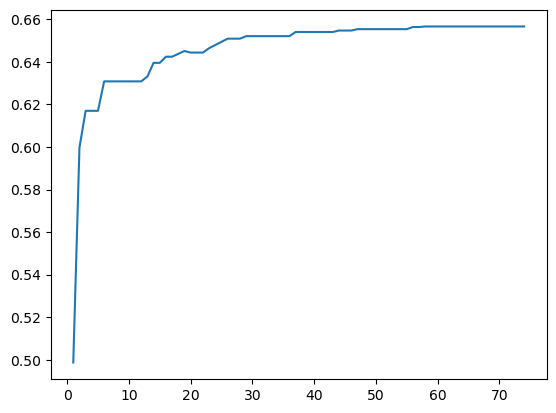

min_samples_leaf     0.010000
ccp_alpha            0.000116
score                0.656677
num_subgroups       58.000000
max rule len        11.000000
Name: 16, dtype: float64
Leaf Order:  [6, 8, 9, 10, 13, 14, 15, 18, 21, 22, 24, 25, 28, 29, 32, 33, 34, 40, 41, 42, 43, 44, 46, 47, 57, 58, 59, 61, 63, 64, 65, 69, 70, 71, 72, 73, 75, 76, 81, 82, 83, 84, 90, 91, 92, 93, 94, 95, 99, 101, 102, 103, 106, 107, 108]
Leaf Order:  [6, 8, 9, 10, 13, 14, 15, 18, 21, 22, 24, 25, 28, 29, 32, 33, 34, 40, 41, 42, 43, 44, 46, 47, 57, 58, 59, 61, 63, 64, 65, 69, 70, 71, 72, 73, 75, 76, 81, 82, 83, 84, 90, 91, 92, 93, 94, 95, 99, 101, 102, 103, 106, 107, 108]
[['triage_acuity', 'triage_pain', 'triage_heartrate', 'age', 'n_hosp_365d', 'triage_resprate'], ['triage_acuity', 'triage_pain', 'triage_heartrate', 'age', 'n_hosp_365d', 'triage_resprate', 'gender'], ['triage_acuity', 'triage_pain', 'triage_heartrate', 'age', 'n_hosp_365d', 'triage_resprate', 'gender'], ['triage_acuity', 'triage_pain', 'triage_hear

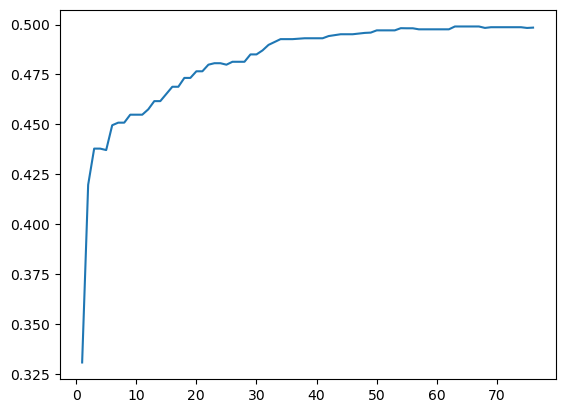

min_samples_leaf     0.010000
ccp_alpha            0.000118
score                0.499044
num_subgroups       63.000000
max rule len        11.000000
Name: 13, dtype: float64
Leaf Order:  [4, 9, 10, 12, 13, 14, 17, 18, 19, 24, 26, 27, 28, 30, 31, 34, 35, 38, 39, 40, 45, 47, 48, 49, 52, 53, 54, 57, 58, 59, 68, 70, 71, 74, 75, 76, 77, 82, 84, 85, 86, 88, 89, 90, 92, 93, 95, 97, 98, 104, 105, 106, 107, 108, 111, 112, 113, 117, 120, 121, 122, 123, 126, 127, 129, 130]
Leaf Order:  [4, 9, 10, 12, 13, 14, 17, 18, 19, 24, 26, 27, 28, 30, 31, 34, 35, 38, 39, 40, 45, 47, 48, 49, 52, 53, 54, 57, 58, 59, 68, 70, 71, 74, 75, 76, 77, 82, 84, 85, 86, 88, 89, 90, 92, 93, 95, 97, 98, 104, 105, 106, 107, 108, 111, 112, 113, 117, 120, 121, 122, 123, 126, 127, 129, 130]
[['triage_acuity', 'triage_pain', 'triage_heartrate', 'age'], ['triage_acuity', 'triage_pain', 'triage_heartrate', 'age', 'age', 'n_hosp_365d', 'triage_resprate', 'gender'], ['triage_acuity', 'triage_pain', 'triage_heartrate', 'age', 'age'

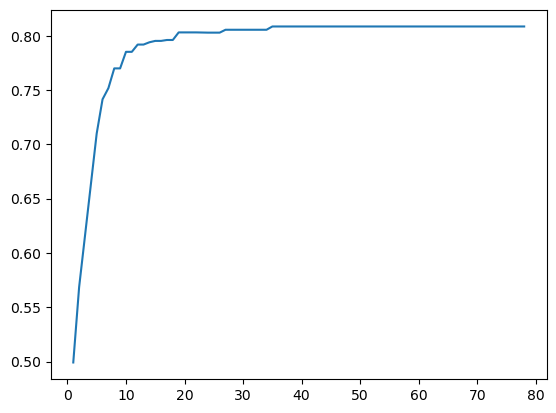

min_samples_leaf     0.010000
ccp_alpha            0.000593
score                0.808471
num_subgroups       35.000000
max rule len         9.000000
Name: 38, dtype: float64
Leaf Order:  [4, 5, 9, 10, 11, 12, 17, 19, 20, 23, 24, 25, 30, 31, 32, 33, 35, 39, 40, 41, 42, 47, 49, 50, 51, 52, 56, 57, 60, 61, 62, 65, 66, 67, 68]
Leaf Order:  [4, 5, 9, 10, 11, 12, 17, 19, 20, 23, 24, 25, 30, 31, 32, 33, 35, 39, 40, 41, 42, 47, 49, 50, 51, 52, 56, 57, 60, 61, 62, 65, 66, 67, 68]
[['triage_acuity', 'age', 'triage_acuity', 'n_hosp_365d'], ['triage_acuity', 'age', 'triage_acuity', 'n_hosp_365d'], ['triage_acuity', 'age', 'triage_acuity', 'n_hosp_365d', 'chiefcom_abdominal_pain', 'triage_o2sat'], ['triage_acuity', 'age', 'triage_acuity', 'n_hosp_365d', 'chiefcom_abdominal_pain', 'triage_o2sat'], ['triage_acuity', 'age', 'triage_acuity', 'n_hosp_365d', 'chiefcom_abdominal_pain'], ['triage_acuity', 'age', 'triage_acuity', 'n_hosp_365d'], ['triage_acuity', 'age', 'triage_acuity', 'age', 'n_hosp_365d

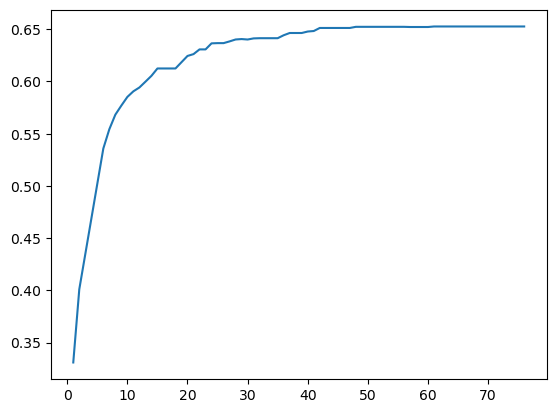

min_samples_leaf     0.010000
ccp_alpha            0.000348
score                0.652666
num_subgroups       61.000000
max rule len        11.000000
Name: 15, dtype: float64
Leaf Order:  [5, 7, 8, 9, 14, 15, 18, 19, 20, 21, 22, 27, 29, 32, 33, 34, 37, 38, 40, 41, 47, 48, 49, 50, 53, 54, 55, 59, 60, 64, 65, 67, 68, 69, 70, 76, 78, 79, 82, 83, 84, 85, 87, 88, 93, 97, 98, 99, 100, 101, 102, 107, 108, 110, 111, 113, 114, 115, 117, 118]
Leaf Order:  [5, 7, 8, 9, 14, 15, 18, 19, 20, 21, 22, 27, 29, 32, 33, 34, 37, 38, 40, 41, 47, 48, 49, 50, 53, 54, 55, 59, 60, 64, 65, 67, 68, 69, 70, 76, 78, 79, 82, 83, 84, 85, 87, 88, 93, 97, 98, 99, 100, 101, 102, 107, 108, 110, 111, 113, 114, 115, 117, 118]
[['triage_acuity', 'age', 'triage_acuity', 'n_hosp_365d', 'triage_pain'], ['triage_acuity', 'age', 'triage_acuity', 'n_hosp_365d', 'triage_pain', 'triage_o2sat'], ['triage_acuity', 'age', 'triage_acuity', 'n_hosp_365d', 'triage_pain', 'triage_o2sat'], ['triage_acuity', 'age', 'triage_acuity', 'n_hosp

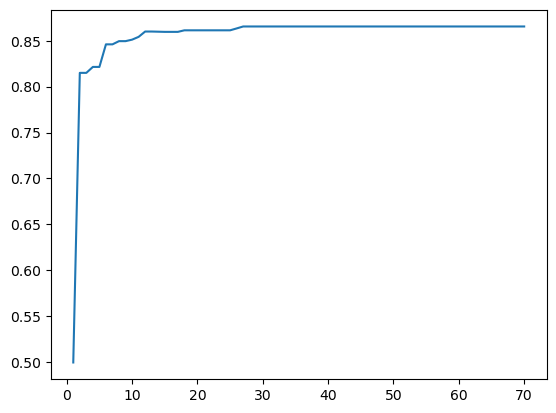

min_samples_leaf     0.010000
ccp_alpha            0.000686
score                0.865490
num_subgroups       27.000000
max rule len         7.000000
Name: 35, dtype: float64
Leaf Order:  [3, 6, 7, 8, 11, 12, 14, 15, 21, 22, 23, 26, 27, 29, 30, 31, 35, 36, 40, 41, 42, 43, 45, 48, 49, 50]
Leaf Order:  [3, 6, 7, 8, 11, 12, 14, 15, 21, 22, 23, 26, 27, 29, 30, 31, 35, 36, 40, 41, 42, 43, 45, 48, 49, 50]
[['triage_acuity', 'age', 'triage_o2sat'], ['triage_acuity', 'age', 'triage_o2sat', 'triage_heartrate', 'gender'], ['triage_acuity', 'age', 'triage_o2sat', 'triage_heartrate', 'gender'], ['triage_acuity', 'age', 'triage_o2sat', 'triage_heartrate'], ['triage_acuity', 'age', 'chiefcom_chest_pain', 'n_ed_365d'], ['triage_acuity', 'age', 'chiefcom_chest_pain', 'n_ed_365d'], ['triage_acuity', 'age', 'chiefcom_chest_pain', 'age'], ['triage_acuity', 'age', 'chiefcom_chest_pain', 'age'], ['triage_acuity', 'age', 'n_icu_365d', 'triage_o2sat', 'triage_heartrate', 'age'], ['triage_acuity', 'age', 'n_i

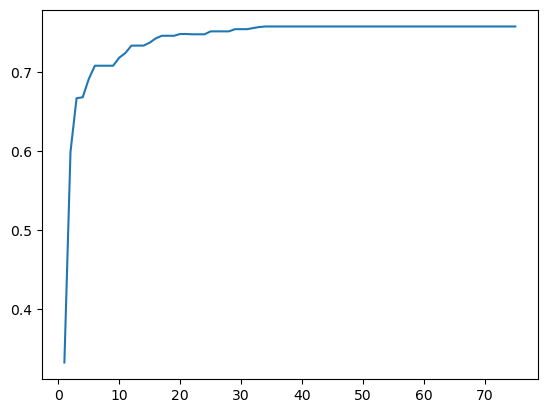

min_samples_leaf     0.010000
ccp_alpha            0.000708
score                0.757794
num_subgroups       34.000000
max rule len         9.000000
Name: 37, dtype: float64
Leaf Order:  [3, 6, 8, 9, 11, 12, 15, 16, 18, 19, 24, 26, 27, 29, 30, 32, 34, 35, 41, 42, 45, 47, 48, 50, 52, 53, 54, 57, 58, 62, 63, 64, 65, 66]
Leaf Order:  [3, 6, 8, 9, 11, 12, 15, 16, 18, 19, 24, 26, 27, 29, 30, 32, 34, 35, 41, 42, 45, 47, 48, 50, 52, 53, 54, 57, 58, 62, 63, 64, 65, 66]
[['triage_acuity', 'age', 'triage_acuity'], ['triage_acuity', 'age', 'triage_acuity', 'triage_heartrate', 'triage_o2sat'], ['triage_acuity', 'age', 'triage_acuity', 'triage_heartrate', 'triage_o2sat', 'age'], ['triage_acuity', 'age', 'triage_acuity', 'triage_heartrate', 'triage_o2sat', 'age'], ['triage_acuity', 'age', 'triage_acuity', 'triage_heartrate', 'age'], ['triage_acuity', 'age', 'triage_acuity', 'triage_heartrate', 'age'], ['triage_acuity', 'age', 'chiefcom_chest_pain', 'triage_o2sat'], ['triage_acuity', 'age', 'chiefco

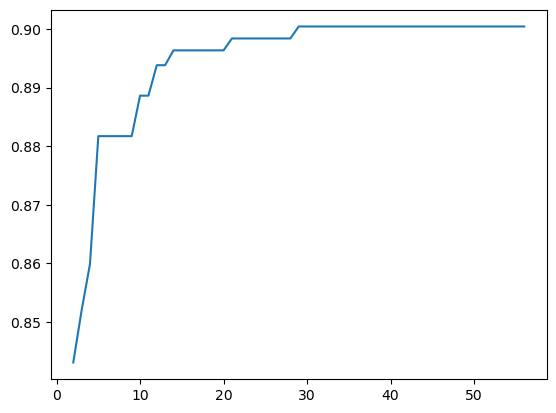

min_samples_leaf     0.010000
ccp_alpha            0.000205
score                0.900443
num_subgroups       29.000000
max rule len         8.000000
Name: 20, dtype: float64
Leaf Order:  [4, 7, 8, 9, 12, 13, 14, 16, 18, 19, 25, 26, 27, 30, 32, 33, 34, 35, 40, 43, 44, 45, 46, 49, 50, 51, 53, 56, 57, 58]
Leaf Order:  [4, 7, 8, 9, 12, 13, 14, 16, 18, 19, 25, 26, 27, 30, 32, 33, 34, 35, 40, 43, 44, 45, 46, 49, 50, 51, 53, 56, 57, 58]
[['triage_acuity', 'age', 'n_ed_365d', 'triage_o2sat'], ['triage_acuity', 'age', 'n_ed_365d', 'triage_o2sat', 'triage_heartrate', 'age'], ['triage_acuity', 'age', 'n_ed_365d', 'triage_o2sat', 'triage_heartrate', 'age'], ['triage_acuity', 'age', 'n_ed_365d', 'triage_o2sat', 'triage_heartrate'], ['triage_acuity', 'age', 'n_ed_365d', 'triage_heartrate', 'triage_o2sat'], ['triage_acuity', 'age', 'n_ed_365d', 'triage_heartrate', 'triage_o2sat'], ['triage_acuity', 'age', 'n_ed_365d', 'triage_heartrate'], ['triage_acuity', 'age', 'chiefcom_chest_pain'], ['triage_acu

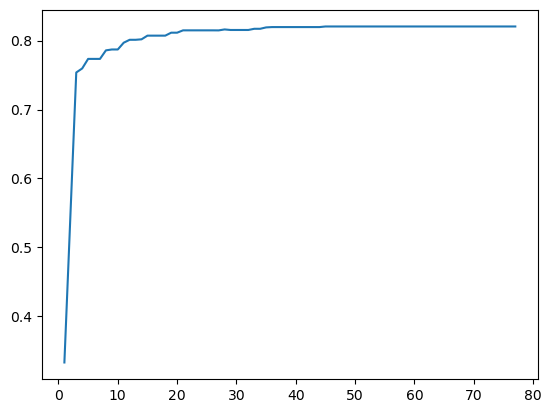

min_samples_leaf     0.010000
ccp_alpha            0.000246
score                0.820536
num_subgroups       45.000000
max rule len        10.000000
Name: 27, dtype: float64
Leaf Order:  [3, 7, 9, 10, 12, 13, 15, 16, 20, 21, 24, 25, 27, 29, 30, 33, 34, 35, 41, 43, 44, 46, 47, 48, 51, 52, 55, 56, 57, 63, 65, 66, 69, 70, 71, 73, 78, 79, 80, 82, 83, 84, 86, 87, 89, 90]
Leaf Order:  [3, 7, 9, 10, 12, 13, 15, 16, 20, 21, 24, 25, 27, 29, 30, 33, 34, 35, 41, 43, 44, 46, 47, 48, 51, 52, 55, 56, 57, 63, 65, 66, 69, 70, 71, 73, 78, 79, 80, 82, 83, 84, 86, 87, 89, 90]
[['triage_acuity', 'age', 'triage_acuity'], ['triage_acuity', 'age', 'triage_acuity', 'triage_heartrate', 'triage_o2sat', 'age'], ['triage_acuity', 'age', 'triage_acuity', 'triage_heartrate', 'triage_o2sat', 'age', 'triage_dbp'], ['triage_acuity', 'age', 'triage_acuity', 'triage_heartrate', 'triage_o2sat', 'age', 'triage_dbp'], ['triage_acuity', 'age', 'triage_acuity', 'triage_heartrate', 'triage_o2sat', 'n_ed_365d'], ['triage_acui

In [3]:
run_experiment(res_key="dissertation_DT_noProb_alpha_newtest", include_probability = False, selection_criteria="amia")

mkdir: cannot create directory ‘RQ 3/results/dissertation_DT_noProb_knee_newtest’: File exists
mkdir: cannot create directory ‘RQ 3/input/dissertation_DT_noProb_knee_newtest’: File exists
TRIAL 1/100
=====NN-dropout trauma_uk 0 2=====
['TRAUMATYPE', 'SYSBP', 'RR', 'GCS', 'EDMOTOR', 'SI', 'SIRANK', 'AGE', 'SEX', 'RTS', 'FlailAMPT', 'SCIAMPT', 'RRAMPT', 'GCSAMPT', 'ABDAMPT', 'ARMAMPT', 'CHESTAMPT', 'FACEAMPT', 'HEADAMPT', 'LEGAMPT', 'NECKAMPT', 'MultisystemAMPT', 'AnatomicalAMPT', 'PhysiologicalAMPT', 'LungAMPT', 'AMPT', 'Mechanism', 'RTSCode', 'AgeGroups', 'SBPCode', 'MotorCode', 'AMPT2']
TRAIN SHAPE:  (43519, 32)
min_samples_leaf = 0.01 | ccp_alpha = 0.0 | val_score = 0.848828125 | no. subgroups = 60 | max rule len = 11
min_samples_leaf = 0.01 | ccp_alpha = 7.305189543035722e-05 | val_score = 0.848828125 | no. subgroups = 40 | max rule len = 9
min_samples_leaf = 0.01 | ccp_alpha = 7.538519232916027e-05 | val_score = 0.848828125 | no. subgroups = 39 | max rule len = 9
min_samples_leaf =

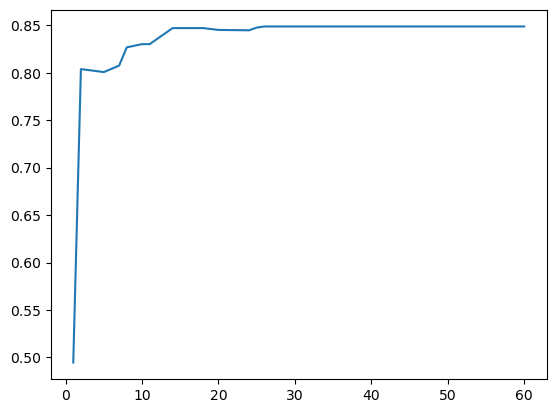

min_samples_leaf    0.010000
ccp_alpha           0.018850
score               0.803906
num_subgroups       2.000000
max rule len        1.000000
Name: 17, dtype: float64
Leaf Order:  [1, 2]
Leaf Order:  [1, 2]
[['AMPT'], ['AMPT']]
test accuracy = 0.8003164000703111 | num. rules = 2
TRIAL 2/100
=====NN-dropout trauma_uk 0 3=====
['TRAUMATYPE', 'SYSBP', 'RR', 'GCS', 'EDMOTOR', 'SI', 'SIRANK', 'AGE', 'SEX', 'RTS', 'FlailAMPT', 'SCIAMPT', 'RRAMPT', 'GCSAMPT', 'ABDAMPT', 'ARMAMPT', 'CHESTAMPT', 'FACEAMPT', 'HEADAMPT', 'LEGAMPT', 'NECKAMPT', 'MultisystemAMPT', 'AnatomicalAMPT', 'PhysiologicalAMPT', 'LungAMPT', 'AMPT', 'Mechanism', 'RTSCode', 'AgeGroups', 'SBPCode', 'MotorCode', 'AMPT2']
TRAIN SHAPE:  (43519, 32)
min_samples_leaf = 0.01 | ccp_alpha = 0.0 | val_score = 0.8338541666666667 | no. subgroups = 71 | max rule len = 15
min_samples_leaf = 0.01 | ccp_alpha = 3.313661406667209e-05 | val_score = 0.8338541666666667 | no. subgroups = 56 | max rule len = 12
min_samples_leaf = 0.01 | ccp_alph

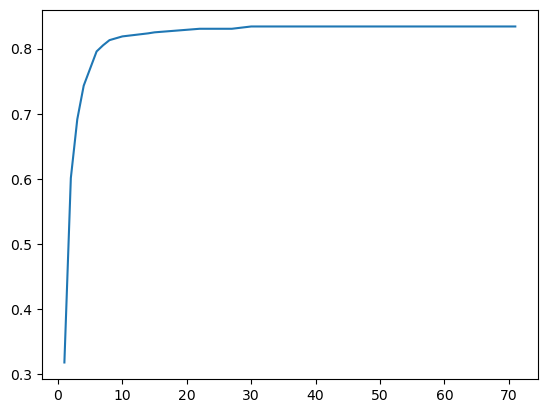

min_samples_leaf    0.010000
ccp_alpha           0.011997
score               0.795573
num_subgroups       6.000000
max rule len        5.000000
Name: 22, dtype: float64
Leaf Order:  [5, 6, 7, 8, 10, 11, 12]
Leaf Order:  [5, 6, 7, 8, 10, 11, 12]
[['AMPT', 'HEADAMPT', 'ABDAMPT', 'CHESTAMPT', 'NECKAMPT'], ['AMPT', 'HEADAMPT', 'ABDAMPT', 'CHESTAMPT', 'NECKAMPT'], ['AMPT', 'HEADAMPT', 'ABDAMPT', 'CHESTAMPT'], ['AMPT', 'HEADAMPT', 'ABDAMPT'], ['AMPT', 'HEADAMPT', 'AGE'], ['AMPT', 'HEADAMPT', 'AGE'], ['AMPT']]
test accuracy = 0.7953946211988047 | num. rules = 7
TRIAL 3/100
=====catboost-ve trauma_uk 0 2=====
['TRAUMATYPE', 'SYSBP', 'RR', 'GCS', 'EDMOTOR', 'SI', 'SIRANK', 'AGE', 'SEX', 'RTS', 'FlailAMPT', 'SCIAMPT', 'RRAMPT', 'GCSAMPT', 'ABDAMPT', 'ARMAMPT', 'CHESTAMPT', 'FACEAMPT', 'HEADAMPT', 'LEGAMPT', 'NECKAMPT', 'MultisystemAMPT', 'AnatomicalAMPT', 'PhysiologicalAMPT', 'LungAMPT', 'AMPT', 'Mechanism', 'RTSCode', 'AgeGroups', 'SBPCode', 'MotorCode', 'AMPT2']
TRAIN SHAPE:  (43519, 32)
min_

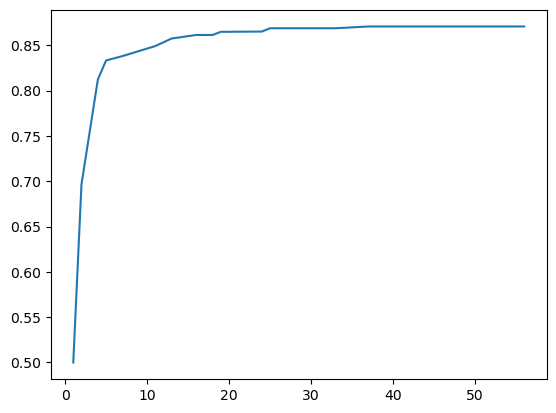

min_samples_leaf    0.010000
ccp_alpha           0.035939
score               0.812240
num_subgroups       4.000000
max rule len        2.000000
Name: 22, dtype: float64
Leaf Order:  [2, 3, 4]
Leaf Order:  [2, 3, 4]
[['HEADAMPT', 'AMPT'], ['HEADAMPT', 'AMPT'], ['HEADAMPT']]
test accuracy = 0.7765863947969767 | num. rules = 3
TRIAL 4/100
=====catboost-ve trauma_uk 0 3=====
['TRAUMATYPE', 'SYSBP', 'RR', 'GCS', 'EDMOTOR', 'SI', 'SIRANK', 'AGE', 'SEX', 'RTS', 'FlailAMPT', 'SCIAMPT', 'RRAMPT', 'GCSAMPT', 'ABDAMPT', 'ARMAMPT', 'CHESTAMPT', 'FACEAMPT', 'HEADAMPT', 'LEGAMPT', 'NECKAMPT', 'MultisystemAMPT', 'AnatomicalAMPT', 'PhysiologicalAMPT', 'LungAMPT', 'AMPT', 'Mechanism', 'RTSCode', 'AgeGroups', 'SBPCode', 'MotorCode', 'AMPT2']
TRAIN SHAPE:  (43519, 32)
min_samples_leaf = 0.01 | ccp_alpha = 0.0 | val_score = 0.8188802083333333 | no. subgroups = 66 | max rule len = 14
min_samples_leaf = 0.01 | ccp_alpha = 1.3468348202842686e-06 | val_score = 0.8188802083333333 | no. subgroups = 64 | max ru

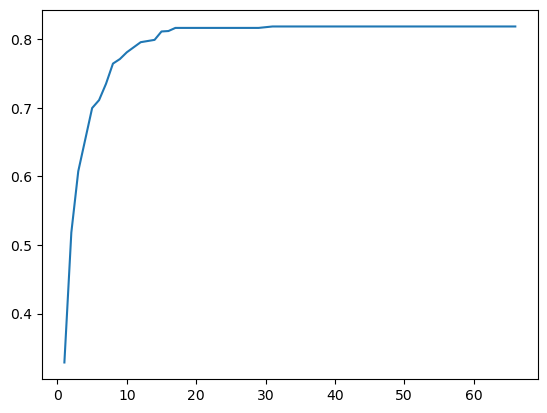

min_samples_leaf    0.010000
ccp_alpha           0.011385
score               0.764714
num_subgroups       8.000000
max rule len        5.000000
Name: 25, dtype: float64
Leaf Order:  [5, 6, 7, 8, 11, 12, 13, 15, 16]
Leaf Order:  [5, 6, 7, 8, 11, 12, 13, 15, 16]
[['AMPT', 'HEADAMPT', 'ABDAMPT', 'CHESTAMPT', 'NECKAMPT'], ['AMPT', 'HEADAMPT', 'ABDAMPT', 'CHESTAMPT', 'NECKAMPT'], ['AMPT', 'HEADAMPT', 'ABDAMPT', 'CHESTAMPT'], ['AMPT', 'HEADAMPT', 'ABDAMPT'], ['AMPT', 'HEADAMPT', 'AGE', 'Mechanism'], ['AMPT', 'HEADAMPT', 'AGE', 'Mechanism'], ['AMPT', 'HEADAMPT', 'AGE'], ['AMPT', 'AMPT'], ['AMPT', 'AMPT']]
test accuracy = 0.7723677271928283 | num. rules = 9
TRIAL 5/100
=====NN-dropout diabetes 0 2=====
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
TRAIN SHAPE:  (587, 8)
min_samples_leaf = 0.01 | ccp_alpha = 0.0 | val_score = 0.6634615384615384 | no. subgroups = 12 | max rule len = 4
min_samples_leaf = 0.01 | ccp_alpha = 0.031

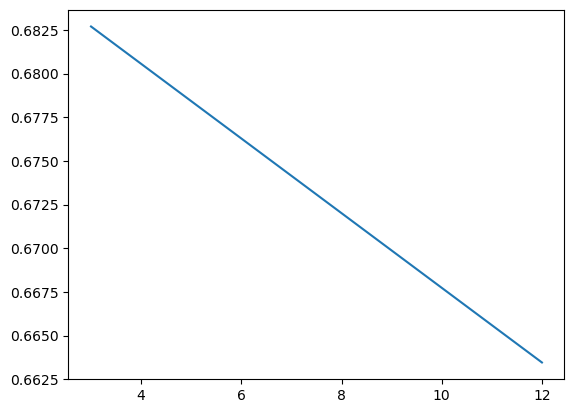

min_samples_leaf    0.010000
ccp_alpha           0.031872
score               0.682692
num_subgroups       3.000000
max rule len        2.000000
Name: 1, dtype: float64
Leaf Order:  [1, 3, 4]
Leaf Order:  [1, 3, 4]
[['Glucose'], ['Glucose', 'Glucose'], ['Glucose', 'Glucose']]
test accuracy = 0.7402597402597403 | num. rules = 3
TRIAL 6/100
=====NN-dropout diabetes 0 3=====
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
TRAIN SHAPE:  (587, 8)
min_samples_leaf = 0.01 | ccp_alpha = 0.0 | val_score = 0.4807692307692308 | no. subgroups = 14 | max rule len = 4
min_samples_leaf = 0.01 | ccp_alpha = 0.03285774045175349 | val_score = 0.4519230769230769 | no. subgroups = 4 | max rule len = 2


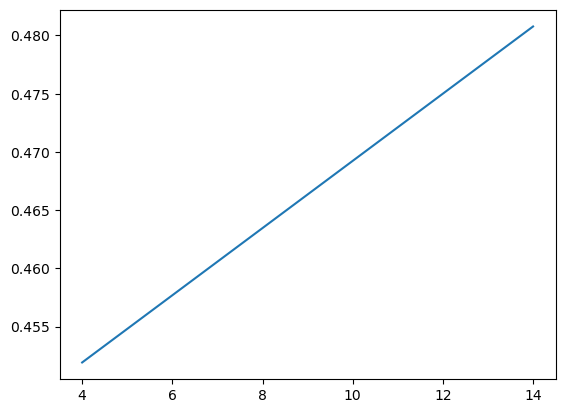

min_samples_leaf    0.010000
ccp_alpha           0.032858
score               0.451923
num_subgroups       4.000000
max rule len        2.000000
Name: 1, dtype: float64
Leaf Order:  [2, 3, 4]
Leaf Order:  [2, 3, 4]
[['Glucose', 'Glucose'], ['Glucose', 'Glucose'], ['Glucose']]
test accuracy = 0.5974025974025974 | num. rules = 3


/home/tntech.edu/kebrown46/miniconda3/envs/py38/lib/python3.8/site-packages/kneed/knee_locator.py:311: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")


TRIAL 7/100
=====catboost-ve diabetes 0 2=====
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
TRAIN SHAPE:  (587, 8)
min_samples_leaf = 0.01 | ccp_alpha = 0.0 | val_score = 0.8269230769230769 | no. subgroups = 14 | max rule len = 4
min_samples_leaf = 0.01 | ccp_alpha = 0.08955698758371616 | val_score = 0.49038461538461536 | no. subgroups = 1 | max rule len = 1


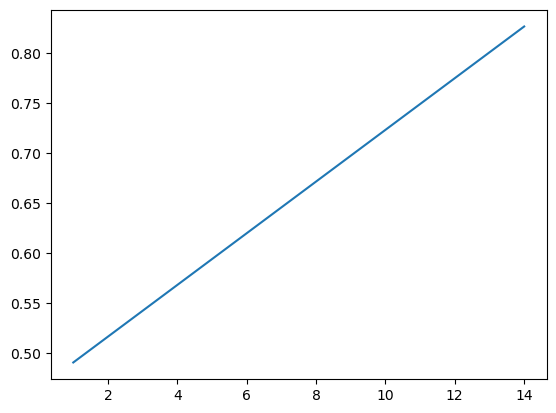

min_samples_leaf    0.010000
ccp_alpha           0.089557
score               0.490385
num_subgroups       1.000000
max rule len        1.000000
Name: 1, dtype: float64
Leaf Order:  [0]
Leaf Order:  [0]
[[]]
test accuracy = 0.4935064935064935 | num. rules = 1


/home/tntech.edu/kebrown46/miniconda3/envs/py38/lib/python3.8/site-packages/kneed/knee_locator.py:311: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")


TRIAL 8/100
=====catboost-ve diabetes 0 3=====
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
TRAIN SHAPE:  (587, 8)
min_samples_leaf = 0.01 | ccp_alpha = 0.0 | val_score = 0.6730769230769231 | no. subgroups = 14 | max rule len = 4
min_samples_leaf = 0.01 | ccp_alpha = 0.07887196830184628 | val_score = 0.3076923076923077 | no. subgroups = 1 | max rule len = 1


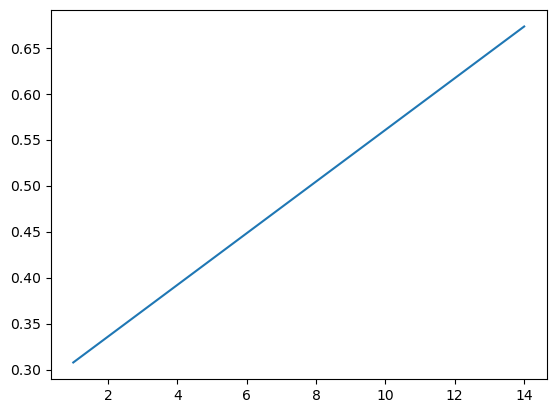

min_samples_leaf    0.010000
ccp_alpha           0.078872
score               0.307692
num_subgroups       1.000000
max rule len        1.000000
Name: 1, dtype: float64
Leaf Order:  [0]
Leaf Order:  [0]
[[]]
test accuracy = 0.3116883116883117 | num. rules = 1


/home/tntech.edu/kebrown46/miniconda3/envs/py38/lib/python3.8/site-packages/kneed/knee_locator.py:311: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")


TRIAL 9/100
=====NN-dropout ED_3day_readmit 0 2=====
['age', 'gender', 'n_ed_30d', 'n_ed_90d', 'n_ed_365d', 'n_hosp_30d', 'n_hosp_90d', 'n_hosp_365d', 'n_icu_30d', 'n_icu_90d', 'n_icu_365d', 'triage_pain', 'triage_acuity', 'chiefcom_chest_pain', 'chiefcom_abdominal_pain', 'chiefcom_headache', 'chiefcom_shortness_of_breath', 'chiefcom_back_pain', 'chiefcom_cough', 'chiefcom_nausea_vomiting', 'chiefcom_fever_chills', 'chiefcom_syncope', 'chiefcom_dizziness', 'cci_MI', 'cci_CHF', 'cci_PVD', 'cci_Stroke', 'cci_Dementia', 'cci_Pulmonary', 'cci_Rheumatic', 'cci_PUD', 'cci_Liver1', 'cci_DM1', 'cci_DM2', 'cci_Paralysis', 'cci_Renal', 'cci_Cancer1', 'cci_Liver2', 'cci_Cancer2', 'cci_HIV', 'eci_Arrhythmia', 'eci_Valvular', 'eci_PHTN', 'eci_HTN1', 'eci_HTN2', 'eci_NeuroOther', 'eci_Hypothyroid', 'eci_Lymphoma', 'eci_Coagulopathy', 'eci_Obesity', 'eci_WeightLoss', 'eci_FluidsLytes', 'eci_BloodLoss', 'eci_Anemia', 'eci_Alcohol', 'eci_Drugs', 'eci_Psychoses', 'eci_Depression', 'ed_temperature_last',

In [ ]:
run_experiment(res_key="dissertation_DT_noProb_knee_newtest", include_probability = False, selection_criteria="elbow")

In [ ]:
run_experiment(res_key="dissertation_DT_noProb_maxleaves_newtest", include_probability = False, selection_criteria="most_leaves")